# Load and plot audio signal

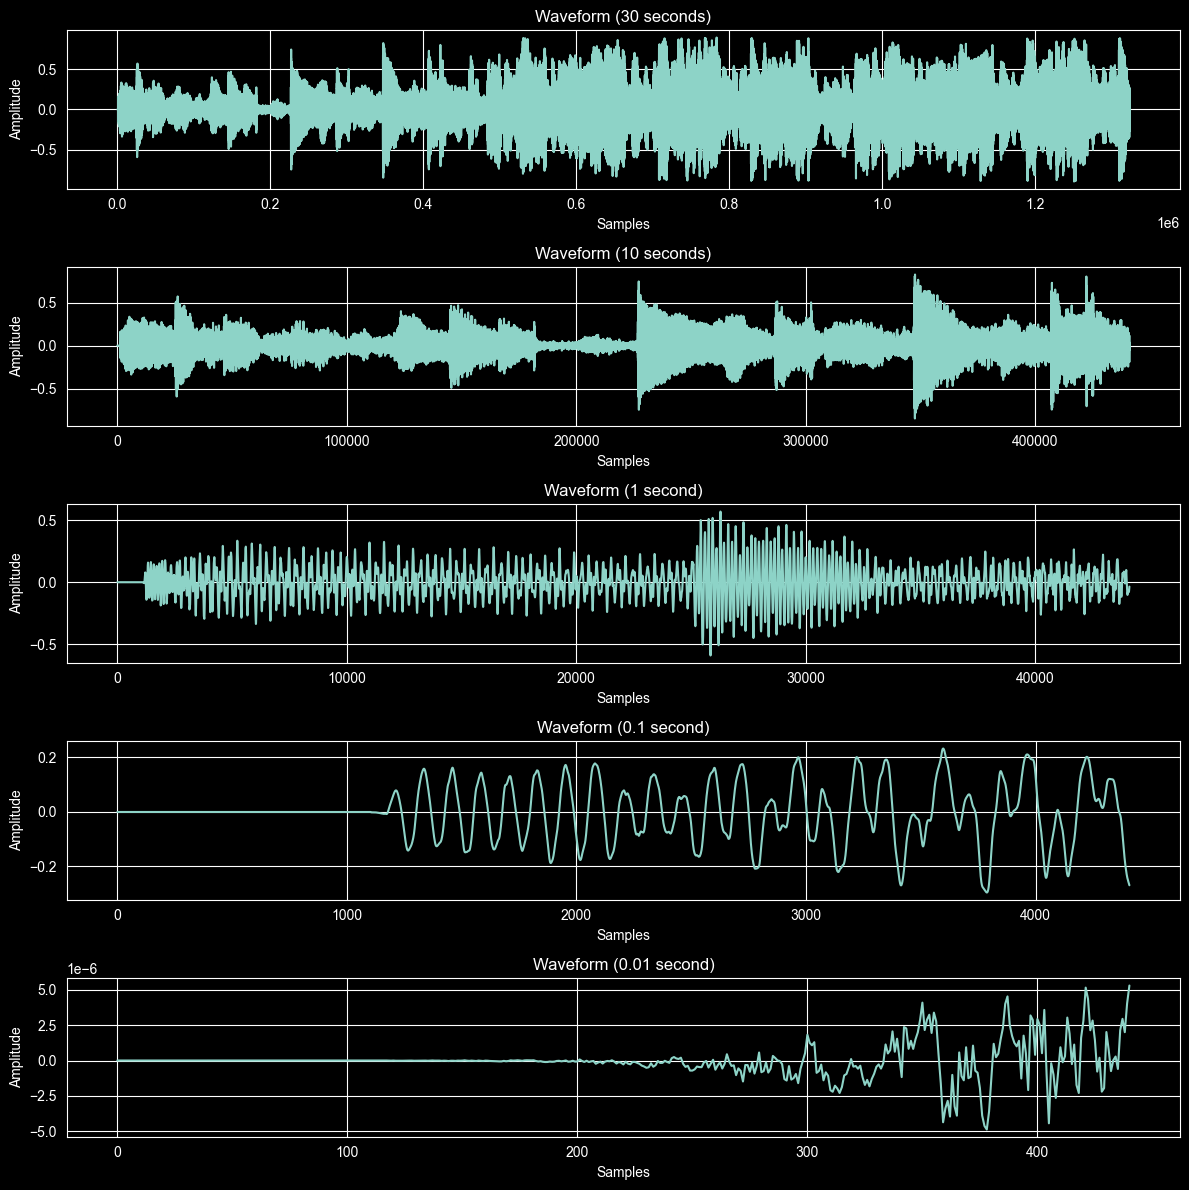

In [1]:
import os
import torchaudio
import matplotlib.pyplot as plt

# ffmpeg path
os.add_dll_directory(r"C:\ffmpeg\bin")

# path for songs
BASE_DIR = os.path.dirname(os.path.abspath('__file__'))
sound_sample_file = os.path.join(BASE_DIR, '..', 'data', '01. Talwiinder, NDS, Rippy Grewal - Haseen.mp3')

# load audio
waveform, sr = torchaudio.load(sound_sample_file)

# durations in seconds
durations = {
    "30 seconds": int(30.0 * sr),
    "10 seconds": int(10.0 * sr),
    "1 second": int(1.0 * sr),
    "0.1 second": int(0.1 * sr),
    "0.01 second": int(0.01 * sr),
}

# create plots
fig, ax = plt.subplots(nrows=len(durations), figsize=(12, 12))

# plot waveforms
for i, (label, samples) in enumerate(durations.items()):
    ax[i].plot(waveform[0][:samples].numpy())
    ax[i].set_title(f"Waveform ({label})")
    ax[i].set_xlabel("Samples")
    ax[i].set_ylabel("Amplitude")

plt.tight_layout()
plt.show()


# Load Spectogram

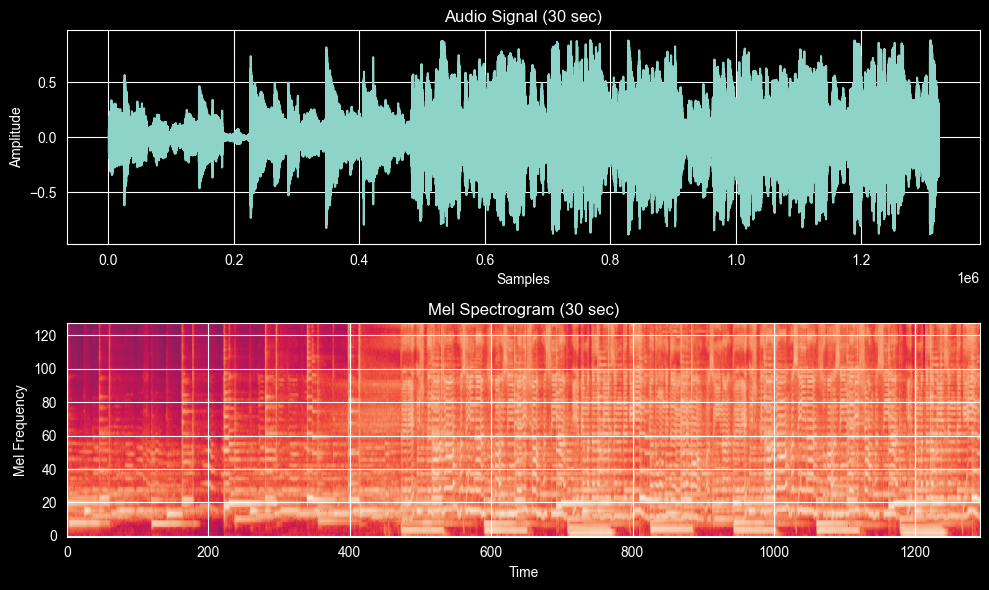

In [2]:
import numpy as np
import torchaudio
import torchaudio.transforms as T
import matplotlib.pyplot as plt
from skimage.transform import resize

# load audio
waveform, sample_rate = torchaudio.load(sound_sample_file)

# convert to mono if stereo
if waveform.shape[0] > 1:
    waveform = waveform.mean(dim=0, keepdim=True)

# limit to first 30 seconds
max_seconds = 30
max_samples = min(waveform.shape[1], max_seconds * sample_rate)
waveform_30s = waveform[:, :max_samples]
signal_30s = waveform_30s[0].numpy()

# mel spectrogram
mel_transform = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=2048,
    n_mels=128,
    f_max=8000
)
mel_spec = mel_transform(waveform_30s)

# convert power spectrogram to dB
mel_db = T.AmplitudeToDB(stype="power")(mel_spec)

# remove channel dimension for plotting
mel_db = mel_db[0].numpy()

# for cnn
# match original scaling and orientation
mel_image = (((80 + mel_db) / 80) * 255)
mel_image = np.flip(mel_image, axis=0)
mel_image = resize(mel_image, (128, 512)).astype(np.uint8)

# create plots
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

# plot waveform
ax[0].plot(signal_30s)
ax[0].set_title(f"Audio Signal ({max_seconds} sec)")
ax[0].set_ylabel("Amplitude")
ax[0].set_xlabel("Samples")

# plot spectrogram
ax[1].imshow(mel_db, origin="lower", aspect="auto")
ax[1].set_title(f"Mel Spectrogram ({max_seconds} sec)")
ax[1].set_ylabel("Mel Frequency")
ax[1].set_xlabel("Time")

plt.tight_layout()
plt.show()

# Create a Dataframe with song file names and paths

In [3]:
import pandas as pd

# path for the songs folder
folder_path = "../data"
files = os.listdir(folder_path)

song_data = []
for file in files:
    if file.endswith((".mp3", ".wav", ".flac")):
        path = os.path.join(folder_path, file)

        # load audio
        waveform, sample_rate = torchaudio.load(path)

        # convert to mono if stereo
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)

        # limit to first 10 seconds
        max_samples = min(waveform.shape[1], 10 * sample_rate)
        waveform = waveform[:, :max_samples]

        # mel spectrogram
        mel_transform = T.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=2048,
            n_mels=128,
            f_max=8000
        )
        mel_spec = mel_transform(waveform)

        # convert power spectrogram to dB
        mel_spec_db = T.AmplitudeToDB(stype="power")(mel_spec)

        # remove channel dimension and convert to numpy
        mel_spec_db = mel_spec_db[0].numpy()

        song_data.append({
            "file_name": file,
            "file_path": path,
            "audio_data": mel_spec_db
        })

# convert to dataframe
df = pd.DataFrame(song_data)
print(df.head())

                                           file_name  \
0          01 - 5 Seconds of Summer - Youngblood.mp3   
1   01 - A.R. Rahman - Enna Sona (From OK Jaanu).mp3   
2  01 - Aaron Smith - Dancin (feat. Luvli) (Krono...   
3               01 - Adele - Rolling in the Deep.mp3   
4   01 - Ajay-Atul - Sapna Jahan (From Brothers).mp3   

                                           file_path  \
0  ../data\01 - 5 Seconds of Summer - Youngblood.mp3   
1  ../data\01 - A.R. Rahman - Enna Sona (From OK ...   
2  ../data\01 - Aaron Smith - Dancin (feat. Luvli...   
3       ../data\01 - Adele - Rolling in the Deep.mp3   
4  ../data\01 - Ajay-Atul - Sapna Jahan (From Bro...   

                                          audio_data  
0  [[-100.0, -100.0, -100.0, -100.0, -100.0, -100...  
1  [[-85.599075, -69.67968, -83.362816, -71.11516...  
2  [[-78.16358, -53.267998, -53.821274, -59.66389...  
3  [[-100.0, -100.0, -100.0, -100.0, -100.0, -100...  
4  [[-84.01452, -85.08353, -75.29413, -66.95749, ..

# Exploratory Data Analysis of Audio Data

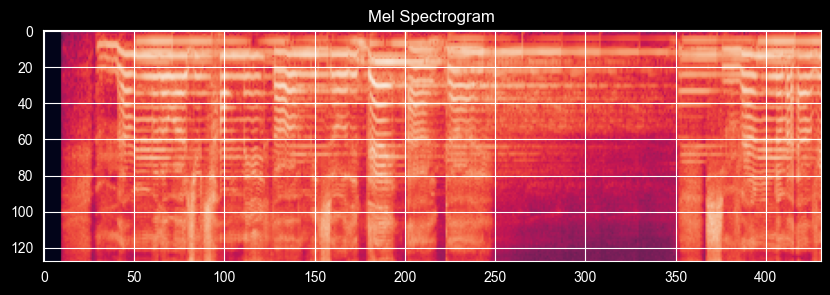

In [4]:
# plot mel spectrogram of the first song
fig, ax = plt.subplots(figsize=(15, 3))
plt.title('Mel Spectrogram')
plt.imshow(df.iloc[0]['audio_data'])

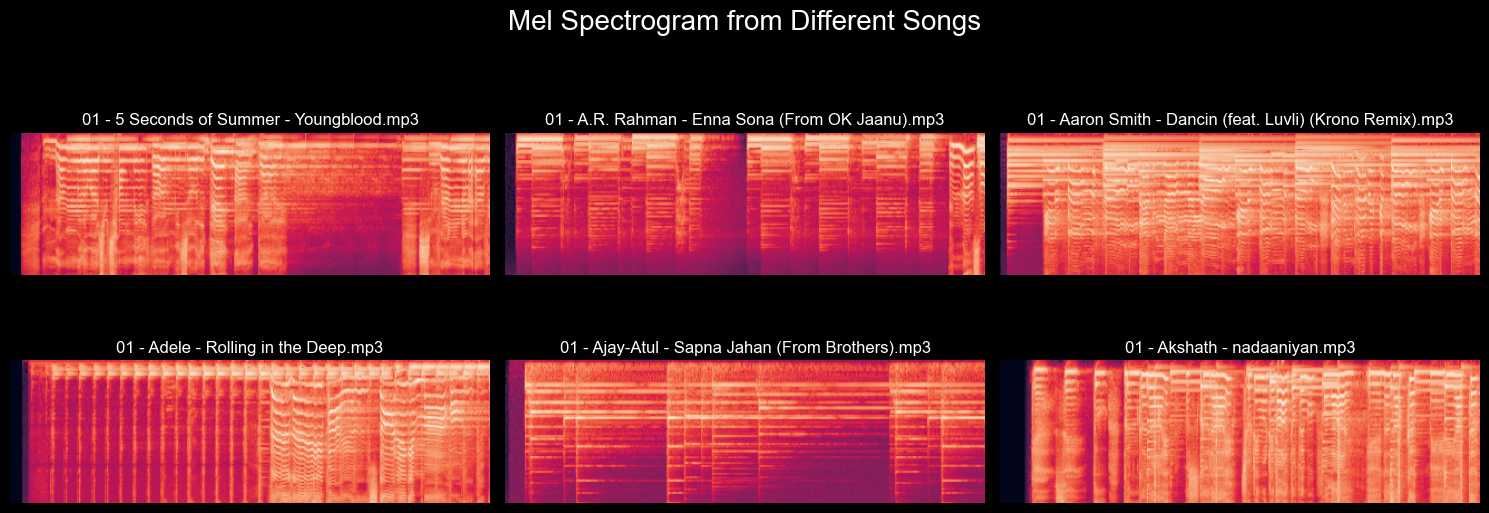

In [5]:
import math

# plot mel spectrogram from different songs
cols = 3
num_songs = 6
rows = math.ceil(num_songs / cols)
fig, ax = plt.subplots(ncols=cols, nrows=rows, figsize=(15, rows*3))

ax_flat = ax.flatten()
plt.suptitle('Mel Spectrogram from Different Songs', fontsize=20)

i = -1
for i in range(num_songs):
    data = df.iloc[i]['audio_data']
    ax_flat[i].imshow(data)
    ax_flat[i].axis('off')
    ax_flat[i].set_title(df.iloc[i]['file_name'])

for j in range(i + 1, len(ax_flat)):
    ax_flat[j].axis('off')

plt.tight_layout()
plt.show()

# Encoder-Decoder Model for Audio Denoising

In [6]:
import torch
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader

class AudioPipeline(Dataset):
    def __init__(self, audio_files, target_sr=44100, duration_sec=5.0):
        self.audio_files = list(audio_files)
        self.target_sr = target_sr
        self.num_samples = int(target_sr * duration_sec)

        self.mel_transform = T.MelSpectrogram(
            sample_rate=target_sr,
            n_mels=128,
            n_fft=2048,
            hop_length=512
        )
        self.db_transform = T.AmplitudeToDB()

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        waveform, sr = torchaudio.load(self.audio_files[idx])

        # convert to mono if stereo
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        # resample if sr doesn't match target
        if sr != self.target_sr:
             resampler = T.Resample(sr, self.target_sr)
             waveform = resampler(waveform)

        # ensure fixed length
        if waveform.shape[1] > self.num_samples: # if long
            waveform = waveform[:, :self.num_samples]
        else: # if short
            padding = self.num_samples - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, padding))

        mel_spec = self.mel_transform(waveform)

        return self.db_transform(mel_spec)


In [7]:
from torch.utils.data import random_split


full_dataset = AudioPipeline(df['file_path'])

# splitting the dataset
train_size = int(0.90 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)